In [ ]:
import os
import pyblp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re 
pyblp.options.verbose = True


path = os.path.join('..', '..', '00_build', 'output', 'df_all.csv')
product_data = pd.read_csv(path)

X1_formulation  = pyblp.Formulation(
    # '0 + num_of_beds + is_airbnb',
    '0 + prices + cleanness_score + location + staff_communication_score + room_score + num_of_beds + num_of_reviews + is_airbnb',
    # '0 + prices + cleanness_score + location + staff_communication_score + room_score + num_of_beds + num_of_reviews + is_airbnb',
    # '0 + prices + cleanness_score + location + staff_communication_score + room_score + num_of_beds + num_of_reviews',
    absorb = 'C(city_ids) + C(day_of_week) + C(month)'
)

# X2_formulation= pyblp.Formulation('0 + prices + num_of_reviews')
X2_formulation= pyblp.Formulation('0 + prices')
# 2_formulation= pyblp.Formulation('0 + prices + room_score + cleanness_score + location + staff_communication_score')


product_formulations_X1_and_X2 = (X1_formulation, X2_formulation)

IVs = pyblp.build_differentiation_instruments(
    pyblp.Formulation(
        '0 + cleanness_score + location + staff_communication_score + room_score + num_of_beds + num_of_reviews'
        ),
    product_data,
    version = 'quadratic',
    interact = True
)

for i, column in enumerate(IVs.T):
    product_data[f'demand_instruments{i}'] = column



mc_integration = pyblp.Integration('monte_carlo', size=200, specification_options={'seed': 0})
# mc_integration = pyblp.Integration('monte_carlo', size=100, specification_options={'seed': 0})

mc_problem_X1_and_X2 = pyblp.Problem(product_formulations_X1_and_X2, product_data, integration = mc_integration)
# mc_problem_X1 = pyblp.Problem(X1_formulation, product_data)

bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-8})
# bfgs = pyblp.Optimization('l-bfgs-b', {'gtol': 1e-8})


# lower = np.diag([None, None, None, None, None])
lower = np.diag([None, None])
# upper = np.diag([-0.01, None, None, None, None])
upper = np.diag([None, None])
initial_sigma = np.diag([-10, 5, 5, 5, 5])


# 列名のリストから" demand_instrument"に該当するものを抽出
instrument_columns = [col for col in product_data.columns if col.startswith('demand_instrument')]

# 各列名の数字部分を抽出して最大値を見つける
max_instrument_num = max([int(re.search(r'\d+', col).group()) for col in instrument_columns])

# 新しい変数名を作成
new_instrument_col = f'demand_instrument{max_instrument_num+1}'

Initializing the problem ...
Absorbing demand-side fixed effects ...
Initialized the problem after 00:00:01.

Dimensions:
 T     N     F     I      K1    K2    MD    ED    H 
---  -----  ---  ------  ----  ----  ----  ----  ---
899  17607  928  179800   8     1     49    3     8 

Formulations:
       Column Indices:           0            1            2                  3                  4            5             6             7    
-----------------------------  ------  ---------------  --------  -------------------------  ----------  -----------  --------------  ---------
 X1: Linear Characteristics    prices  cleanness_score  location  staff_communication_score  room_score  num_of_beds  num_of_reviews  is_airbnb
X2: Nonlinear Characteristics  prices                                                                                                          


In [2]:
df_for_ownership_matrix = product_data.copy()
df_for_ownership_matrix = df_for_ownership_matrix.drop(columns=['firm_ids'])
df_for_ownership_matrix = df_for_ownership_matrix.rename(columns={'merger_ids': 'firm_ids'})

def get_room_type_for_firm_id(x):
    # firm_ids が 'X' の行をフィルタして、room_type の値を取得
    room_type_value = df_for_ownership_matrix[df_for_ownership_matrix['firm_ids'] == x]['room_type'].values
    return room_type_value[0] if len(room_type_value) > 0 else None

def kappa_specification(f, g):
    # f, gはfirm_idsの値を受け取るらしい。
    # print("f = ", f)
    # print("g = ", g)
    
    if f == g:
       return 1
    if f == 'Airbnb' and get_room_type_for_firm_id(g) == 'Airbnb':
        return 1
    else:
        return 0

ownership_matrix = pyblp.build_ownership(df_for_ownership_matrix, kappa_specification)

In [ ]:
##########################################################
# BLP Estimation by PyBLP
##########################################################

##########################################################
# Random Coefficient Nested Logit Model
##########################################################
def solve_nl(df):
    groups = df.groupby(['market_ids', 'nesting_ids'])
    df[new_instrument_col] = groups['shares'].transform(np.size)
    
    problem = pyblp.Problem(product_formulations_X1_and_X2, df, integration = mc_integration)
    # problem = pyblp.Problem(X1_formulation, df)
    
    return problem.solve(
        rho = 0.7,
        sigma=np.diag([-5]),
        sigma_bounds= (None, None),
        # sigma_bounds= (lower, upper),
        W_type='clustered',
        se_type='clustered'
        )

results = solve_nl(product_data)

##########################################################
# Random Coefficient Logit Model
##########################################################
# with pyblp.parallel(2):
#     results = mc_problem_X1_and_X2.solve(
#         sigma=np.diag([-20]),
#         # sigma=initial_sigma,
#         #sigma_bounds= (lower, upper),
#         sigma_bounds= (None, None),
#         optimization=bfgs,
#         # W_type='clustered',
#         # se_type='clustered',
#         )
    # Plain Logit Model
    # results = mc_problem_X1.solve(optimization=bfgs, se_type='clustered')


#############################
# Post Estimatinon Analysis
#############################

with pyblp.parallel(2):
    # Marginal Costs
    costs = results.compute_costs()

    # HHI, Profits, Consumer Surplus, Markups
    hhi = results.compute_hhi()
    profits = results.compute_profits(costs=costs)
    cs = results.compute_consumer_surpluses()
    markups = results.compute_markups(costs=costs)

    elasticities = results.compute_elasticities()
    diversions = results.compute_diversion_ratios()

    means = results.extract_diagonal_means(elasticities)
    aggregates = results.compute_aggregate_elasticities(factor=0.1)

    # product_dataのmerger_ids列がAirbnbの場合、costsの対応する要素を0に設定
    mask = product_data['merger_ids'] == 'Airbnb'
    new_costs = costs.copy()  # costsをコピーして新しい変数new_costsを作成
    new_costs[mask] = 0  # Airbnbに該当する部分だけnew_costsを変更
    
    # Counterfactuals
    changed_prices = results.compute_prices(
        firm_ids = product_data['merger_ids'],
        ownership = ownership_matrix,
        # costs=new_costs  # new_costsを使用
        costs = costs
    )

    changed_shares = results.compute_shares(changed_prices)
    changed_profits = results.compute_profits(changed_prices, changed_shares, costs) 
    # changed_profits = results.compute_profits(changed_prices, changed_shares, new_costs) 
    changed_cs = results.compute_consumer_surpluses(changed_prices)
    changed_markups = results.compute_markups(changed_prices, costs)
    # changed_markups = results.compute_markups(changed_prices, new_costs)
    changed_hhi = results.compute_hhi(shares=changed_shares)

In [29]:
# (changed_cs - cs) / cs の計算
relative_change = (changed_cs - cs) / cs * 100

# 必要な統計量を計算
mean_value = np.mean(relative_change)
min_value = np.min(relative_change)
max_value = np.max(relative_change)
median_value = np.median(relative_change)
std_value = np.std(relative_change)
# ユニークな値を取得
unique_values = np.unique(relative_change)

# 結果を表示
# print("Unique values:")
# print(unique_values)
# 結果を表示
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Min: {min_value}")
print(f"Max: {max_value}")
print(f"Standard Deviation: {std_value}")

Mean: -0.9951227025967774
Median: -3.903109593103336e-14
Min: -17.096441991287755
Max: 14.172337415267766
Standard Deviation: 4.0075437011969965


In [13]:
relative_change_profits = (changed_profits - profits) / profits * 100

# 必要な統計量を計算
mean_value_profits = np.mean(relative_change_profits)
min_value_profits = np.min(relative_change_profits)
max_value_profits = np.max(relative_change_profits)
median_value_profits = np.median(relative_change_profits)
std_value_profits = np.std(relative_change_profits)

# 結果を表示
print(f"Mean: {mean_value_profits}")
print(f"Median: {median_value_profits}")
print(f"Min: {min_value_profits}")
print(f"Max: {max_value_profits}")
print(f"Standard Deviation: {std_value_profits}")

Mean: 0.8275391711011149
Median: 4.4474845878558016e-14
Min: -32.35920381389747
Max: 33.38447921485756
Standard Deviation: 3.4940067500715575


In [21]:
len(changed_markups)

17607

In [23]:
# 配列のリスト
arrays_to_add = {
    'costs': costs,
    'mergered_costs': new_costs,
    # 'hhi': hhi,
    'profits': profits,
    'changed_profits': changed_profits,
    # 'cs': cs,
    'markups': markups,
    'changed_markups': changed_markups,
    # 'elasticities': elasticities,
    # 'diversions': diversions,
    # 'means': means,
    # 'aggregates': aggregates,
    'changed_prices': changed_prices,
    'changed_shares': changed_shares,
    # 'changed_cs': changed_cs
    'delta': results.delta,
    'xi_fe': results.xi_fe,
    'xi': results.xi,
}

# product_dataに各配列を新しい列として追加
for name, array in arrays_to_add.items():
    # 配列を1次元に変換（必要であれば）
    array = array.flatten() if array.ndim > 1 else array
    product_data[name] = array

# market_ids に対応する cs と changed_cs の辞書をそれぞれ作成
market_ids_unique = product_data['market_ids'].unique()

cs_dict = dict(zip(market_ids_unique, cs))
changed_cs_dict = dict(zip(market_ids_unique, changed_cs))
hhi_dict = dict(zip(market_ids_unique, hhi))
changed_hhi_dict = dict(zip(market_ids_unique, changed_hhi))
changed_shares_dict = dict(zip(market_ids_unique, changed_shares))
means_elasticities_dict = dict(zip(market_ids_unique, means))
aggregates_elasticities_dict = dict(zip(market_ids_unique, aggregates))

# map() を使って、それぞれの列に値を割り当て
product_data['cs'] = product_data['market_ids'].map(cs_dict)
product_data['changed_cs'] = product_data['market_ids'].map(changed_cs_dict)
product_data['hhi'] = product_data['market_ids'].map(hhi_dict)
product_data['changed_hhi'] = product_data['market_ids'].map(changed_hhi_dict)
product_data['changed_shares'] = product_data['market_ids'].map(changed_shares_dict)
product_data['means_elasticities'] = product_data['market_ids'].map(means_elasticities_dict)
product_data['aggregates_elasticities'] = product_data['market_ids'].map(aggregates_elasticities_dict)

# path = "/Users/hanazawakaede/Library/CloudStorage/Dropbox/02_Projects/Airbnb/01_analysis/05_output_all/product_data_plain_logit.csv"
# path = "/Users/hanazawakaede/Library/CloudStorage/Dropbox/02_Projects/Airbnb/01_analysis/05_output_all/product_data_random_coefficient_logit.csv"
# path = "/Users/hanazawakaede/Library/CloudStorage/Dropbox/02_Projects/Airbnb/01_analysis/05_output_all/product_data_nested_logit.csv"
path = "/Users/hanazawakaede/Library/CloudStorage/Dropbox/02_Projects/Airbnb/01_analysis/05_output_all/product_data_random_coefficient_nested_logit.csv"

# product_dataを指定されたパスに書き出し
product_data.to_csv(path, index=False)

# # changed_profitsとhhiをDataFrameに変換
# output_df = pd.DataFrame({
#     'changed_profits': changed_profits.flatten(),
# })

# # 指定されたパスに書き出し
# output_path = "/Users/hanazawakaede/Library/CloudStorage/Dropbox/02_Projects/Airbnb/01_analysis/05_output_all/changed_profit.csv"
# output_df.to_csv(output_path, index=False)

# # changed_profitsとhhiをDataFrameに変換
# output_df = pd.DataFrame({
#     'changed_markups': changed_markups.flatten(),
# })

# # 指定されたパスに書き出し
# output_path = "/Users/hanazawakaede/Library/CloudStorage/Dropbox/02_Projects/Airbnb/01_analysis/05_output_all/changed_markups.csv"
# output_df.to_csv(output_path, index=False)

In [35]:
bootstrapped_results = results.bootstrap(draws=1000, seed=0)

Bootstrapping results ...
Bootstrapped results after 00:18:40.

Bootstrapped Results Summary:
Computation  Bootstrap
   Time        Draws  
-----------  ---------
 00:18:40      1000   


In [ ]:
# パラメータ名のリスト
param_names = ["prices", "room_score", "cleanness_score", "location", "staff_communication_score", 
               # "is_airbnb",
               "num_of_reviews",
                "num_of_beds"]

# データフレームを保存するためのリスト
dataframes = []

# 各パラメータに対する信頼区間の計算
for i, param_name in enumerate(param_names):
    params = bootstrapped_results.bootstrapped_beta[:, i, 0]
    
    # 各信頼区間を計算し、文字列形式に変換
    lower_90, upper_90 = np.percentile(params, [5, 95])
    lower_95, upper_95 = np.percentile(params, [2.5, 97.5])
    lower_99, upper_99 = np.percentile(params, [0.5, 99.5])
    
    ci_90 = f"[{lower_90:.6f}, {upper_90:.6f}]"
    ci_95 = f"[{lower_95:.6f}, {upper_95:.6f}]"
    ci_99 = f"[{lower_99:.6f}, {upper_99:.6f}]"
    
    # データフレームとして保存
    df = pd.DataFrame({
        "param_value": params,
        "param": param_name,
        "CI_90": ci_90,
        "CI_95": ci_95,
        "CI_99": ci_99
    })
    
    # リストに追加
    dataframes.append(df)



rho_params = bootstrapped_results.bootstrapped_rho.reshape(-1)
lower_90, upper_90 = np.percentile(rho_params, [5, 95])
lower_95, upper_95 = np.percentile(rho_params, [2.5, 97.5])
lower_99, upper_99 = np.percentile(rho_params, [0.5, 99.5])

ci_90 = f"[{lower_90:.6f}, {upper_90:.6f}]"
ci_95 = f"[{lower_95:.6f}, {upper_95:.6f}]"
ci_99 = f"[{lower_99:.6f}, {upper_99:.6f}]"

# rho データフレームを作成
sigma_df = pd.DataFrame({
    "param_value": rho_params,
    'param': 'rho',
    "CI_90": ci_90,
    "CI_95": ci_95,
    "CI_99": ci_99
})
# rhoをリストに追加
dataframes.append(sigma_df)

# sigma の処理
# sigma_params = bootstrapped_results.bootstrapped_sigma.reshape(-1)
# lower_90, upper_90 = np.percentile(sigma_params, [5, 95])
# lower_95, upper_95 = np.percentile(sigma_params, [2.5, 97.5])
# lower_99, upper_99 = np.percentile(sigma_params, [0.5, 99.5])

# ci_90 = f"[{lower_90:.6f}, {upper_90:.6f}]"
# ci_95 = f"[{lower_95:.6f}, {upper_95:.6f}]"
# ci_99 = f"[{lower_99:.6f}, {upper_99:.6f}]"

# # sigma データフレームを作成
# sigma_df = pd.DataFrame({
#     "param_value": sigma_params,
#     "param": "sigma",
#     "CI_90": ci_90,
#     "CI_95": ci_95,
#     "CI_99": ci_99
# })

# # sigmaをリストに追加
# dataframes.append(sigma_df)

# 全てのデータフレームを連結して1つのデータフレームにする
all_params_df = pd.concat(dataframes, ignore_index=True)

# 結果を確認する


# CSVファイルとして指定したパスに書き出し
output_path = "/Users/hanazawakaede/Library/CloudStorage/Dropbox/02_Projects/Airbnb/01_analysis/05_output_all/params_output_Nested_Logit.csv"
all_params_df.to_csv(output_path, index=False)

: 

In [12]:
bootstrapped_results.bootstrapped_rho.shape

(5000, 1, 1)

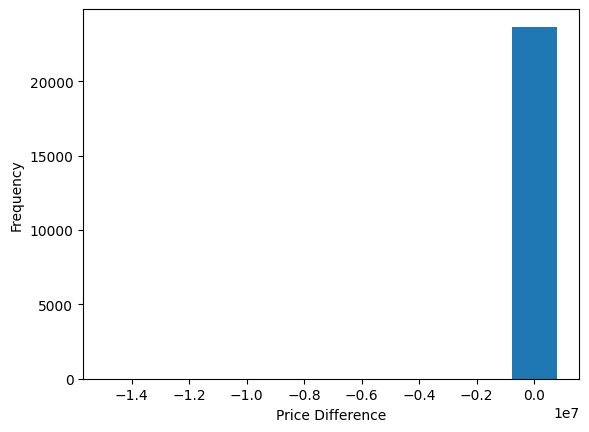

In [105]:
changed_prices_flat = changed_prices.flatten()
price_difference = changed_prices_flat - product_data['prices'].values
plt.hist(price_difference)
plt.xlabel('Price Difference')
plt.ylabel('Frequency')
plt.show()

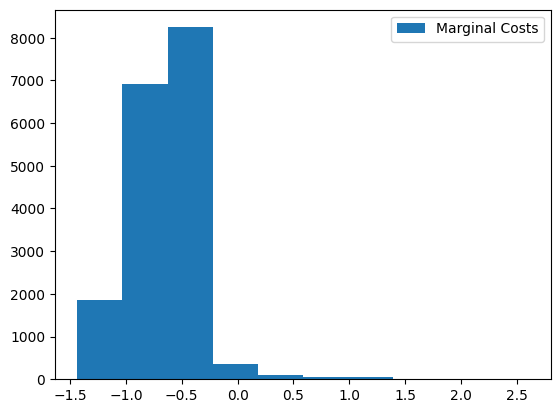

In [22]:
plt.hist(costs);
plt.legend(["Marginal Costs"]);

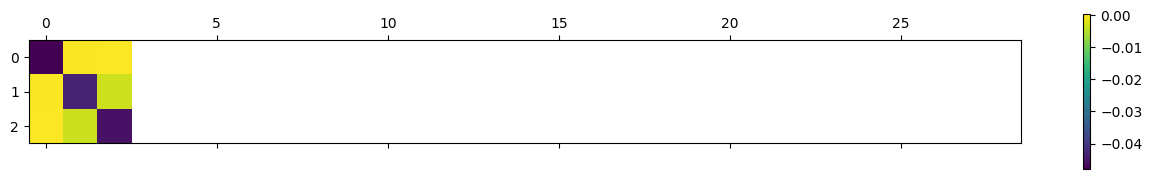

In [103]:
single_market = product_data['market_ids'] == '2024-03-09:ota:5'
plt.colorbar(plt.matshow(elasticities[single_market]));

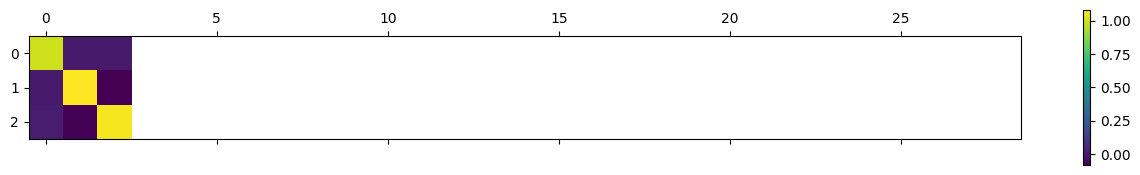

In [104]:
plt.colorbar(plt.matshow(diversions[single_market]));

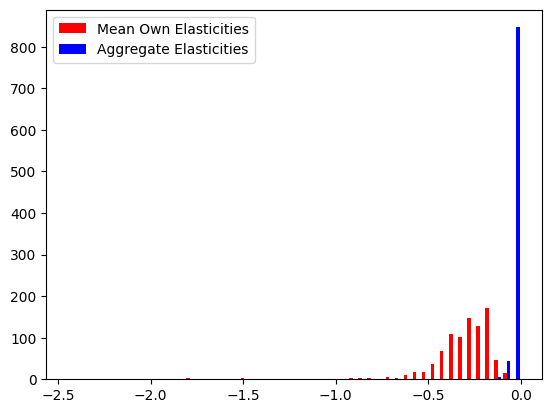

In [23]:
plt.hist(
    [means.flatten(), aggregates.flatten()],
    color=['red', 'blue'],
    bins=50
);
plt.legend(['Mean Own Elasticities', 'Aggregate Elasticities']);

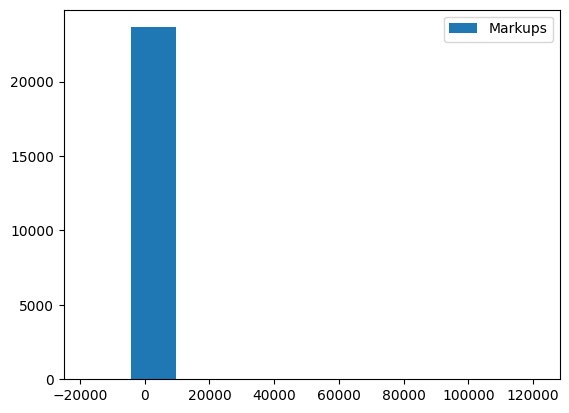

In [108]:
plt.hist(markups);
plt.legend(["Markups"]);

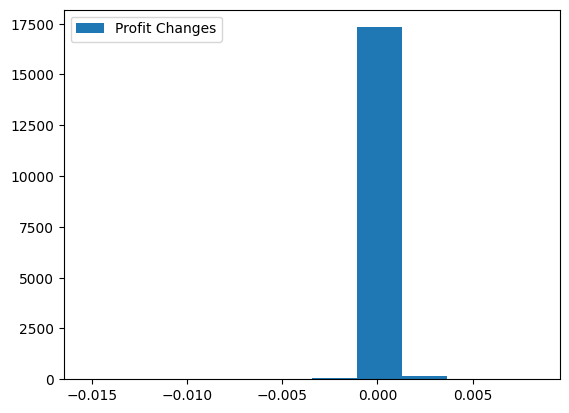

In [107]:
plt.hist(changed_profits - profits);
# plt.xlim(-50, 50)
plt.legend(["Profit Changes"]);

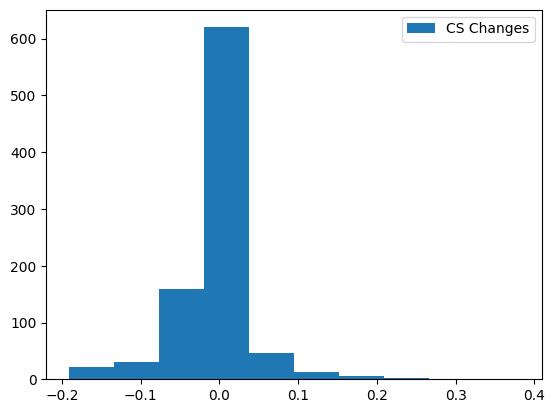

In [108]:
plt.hist((changed_cs - cs)/ cs);
plt.legend(["CS Changes"]);